In [1]:
%matplotlib inline
import os
import copy
import textwrap

import cv2
import torch
import matplotlib.pyplot as plt

import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

torch.set_grad_enabled(False)
setup_logger();

In [2]:
print(
    f'PyTorch: {torch.__version__}\n'
    f'Detectron: {detectron2.__version__}'
)

PyTorch: 1.4.0
Detectron: 0.1


In [3]:
cfg = get_cfg()
cfg.merge_from_file(os.path.expanduser("~/detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))

WARNING [01/14 10:03:00 d2.config.compat]: Config '/home/federico/detectron2/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


## COCO object classes

In [4]:
objects = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
for class_idx, class_name in enumerate(objects):
    print(f'{class_idx:2} {class_name:15}', end='\n' if (class_idx + 1) % 4 == 0 else ' ')

 0 person           1 bicycle          2 car              3 motorcycle     
 4 airplane         5 bus              6 train            7 truck          
 8 boat             9 traffic light   10 fire hydrant    11 stop sign      
12 parking meter   13 bench           14 bird            15 cat            
16 dog             17 horse           18 sheep           19 cow            
20 elephant        21 bear            22 zebra           23 giraffe        
24 backpack        25 umbrella        26 handbag         27 tie            
28 suitcase        29 frisbee         30 skis            31 snowboard      
32 sports ball     33 kite            34 baseball bat    35 baseball glove 
36 skateboard      37 surfboard       38 tennis racket   39 bottle         
40 wine glass      41 cup             42 fork            43 knife          
44 spoon           45 bowl            46 banana          47 apple          
48 sandwich        49 orange          50 broccoli        51 carrot         
52 hot dog  

## Getting boxes

Photo by <a href="https://unsplash.com/@marvelous?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Marvin Meyer</a> on <a href="/s/photos/office?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a>

<img src="./marvin-meyer-SYTO3xs06fU-unsplash.jpg" alt="drawing" width="800"/>

In [5]:
def show_img(img, title='', figsize=(8, 6)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img)
    ax.set_title(title)
    ax.set_axis_off()

In [6]:
original_image = cv2.imread("./marvin-meyer-SYTO3xs06fU-unsplash.jpg")
# show_img(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), figsize=(12, 8));

# OpenCV format: (H, W, C), where C represents BGR
original_image.shape

(4000, 6000, 3)

In [7]:
# Set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Pretrained model from detectron2's model zoo
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl"
predictor = DefaultPredictor(cfg)

In [8]:
outputs = predictor(original_image)
for box_idx, class_idx, class_score in zip(
    range(len(outputs['instances'])), 
    outputs['instances'].pred_classes, 
    outputs['instances'].scores.cpu().numpy()
):
    print(f'{box_idx:2}: {objects[class_idx]:12} {class_score:.2%}')

 0: person       99.65%
 1: laptop       99.62%
 2: person       97.58%
 3: cell phone   95.36%
 4: cell phone   95.27%
 5: laptop       95.22%
 6: laptop       94.78%
 7: laptop       91.66%
 8: cup          91.10%
 9: keyboard     87.96%
10: cup          83.77%
11: keyboard     83.08%
12: book         81.37%
13: keyboard     77.79%
14: book         71.61%
15: cell phone   71.39%
16: laptop       70.89%
17: bottle       67.23%
18: laptop       66.64%
19: laptop       57.63%
20: keyboard     55.90%
21: bowl         50.03%


In [9]:
v = Visualizer(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=.3)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# show_img(v.get_image(), figsize=(12,8))
cv2.imwrite("./marvin-meyer-SYTO3xs06fU-unsplash_detections.jpg", cv2.cvtColor(v.get_image(), cv2.COLOR_RGB2BGR));

<img src="./marvin-meyer-SYTO3xs06fU-unsplash_detections.jpg" alt="drawing" width="800"/>

Box `10` is a cup, this is to check the coordinates of the box.

Top left: 1459.004 1447.2773
Bottom right: 1888.142 1860.0068


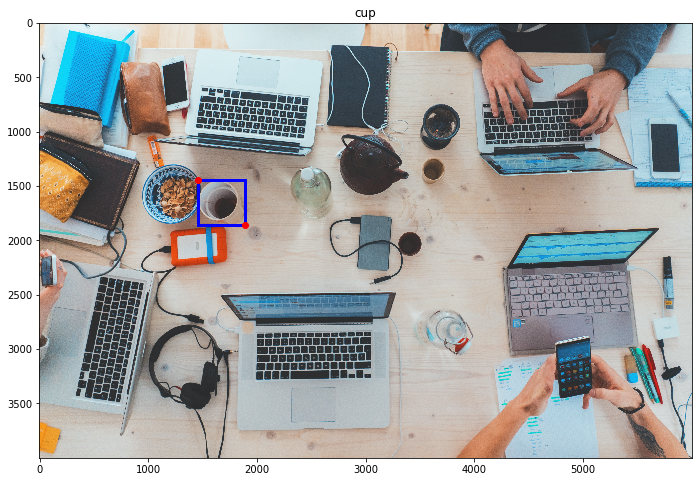

In [10]:
i = 10
x0,y0,x1,y1 = outputs['instances'].pred_boxes.tensor[i].cpu().numpy()
print('Top left:', x0, y0)
print('Bottom right:', x1, y1)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
ax.scatter(x0,y0, c='r', zorder=1000)
ax.scatter(x1,y1, c='r', zorder=1000)
ax.set_title(objects[outputs['instances'].pred_classes[i]])
ax.add_patch(plt.Rectangle(
    (x0,y0), 
    width=x1-x0, 
    height=y1-y0, 
    fill=False,
    linewidth=3,
    color='blue'
));

## Detectron components

The model is a GeneralizedRCNN. The main components of this are:
- `backbone`
- `proposal_generator`
- `roi_heads`

In [11]:
print(predictor.model.__class__)
print(predictor.model.__class__.__doc__)

<class 'detectron2.modeling.meta_arch.rcnn.GeneralizedRCNN'>

    Generalized R-CNN. Any models that contains the following three components:
    1. Per-image feature extraction (aka backbone)
    2. Region proposal generation
    3. Per-region feature extraction and prediction
    


The backbone is a Feature Pyramid Network on top of a ResNet.

An image goes through a ResNet, feature maps are collected at various levels and aggregated into pyramids.

In [12]:
print(predictor.model.backbone.__class__)
print(predictor.model.backbone.__class__.__doc__)

print(predictor.model.backbone.bottom_up.__class__)
# print(predictor.model.backbone.bottom_up.__class__.__doc__)

<class 'detectron2.modeling.backbone.fpn.FPN'>

    This module implements Feature Pyramid Network.
    It creates pyramid features built on top of some input feature maps.
    
<class 'detectron2.modeling.backbone.resnet.ResNet'>


The proposal generator is a Region Proposal Network.

It turns _anchor_ boxes into _proposal_ boxes, each having coordinate deltas and an objectness score:

1. Anchors are created for the given image (anchors depend only on image size)
2. Anchor deltas and objectness scores are predicted at every location and at every level of the pyramid
3. Filter the proposals:
  1. Top K per level per image
  2. Run NMS per level per image
  3. Top K per image (all levels together)

In [13]:
print(predictor.model.proposal_generator.__class__)
print(predictor.model.proposal_generator.__class__.__doc__)

print('anchor_generator', predictor.model.proposal_generator.anchor_generator.__class__)
print(predictor.model.proposal_generator.anchor_generator.__class__.__doc__)

print('rpn_head', predictor.model.proposal_generator.rpn_head.__class__)
print(predictor.model.proposal_generator.rpn_head.__class__.__doc__)

print('box2box_transform', predictor.model.proposal_generator.box2box_transform.__class__)
print(predictor.model.proposal_generator.box2box_transform.__class__.__doc__)

print('RPNOutputs', detectron2.modeling.proposal_generator.rpn_outputs.RPNOutputs)
print(detectron2.modeling.proposal_generator.rpn_outputs.RPNOutputs.__init__.__doc__)

print('find_top_rpn_proposals', detectron2.modeling.proposal_generator.rpn_outputs.find_top_rpn_proposals)
print(detectron2.modeling.proposal_generator.rpn_outputs.find_top_rpn_proposals.__doc__)

# Only used during training to match filtered proposals to ground-truth boxes
# print('anchor_matcher', predictor.model.proposal_generator.anchor_matcher.__class__)
# print(predictor.model.proposal_generator.anchor_matcher.__class__.__doc__)

<class 'detectron2.modeling.proposal_generator.rpn.RPN'>

    Region Proposal Network, introduced by the Faster R-CNN paper.
    
anchor_generator <class 'detectron2.modeling.anchor_generator.DefaultAnchorGenerator'>

    For a set of image sizes and feature maps, computes a set of anchors.
    
rpn_head <class 'detectron2.modeling.proposal_generator.rpn.StandardRPNHead'>

    RPN classification and regression heads. Uses a 3x3 conv to produce a shared
    hidden state from which one 1x1 conv predicts objectness logits for each anchor
    and a second 1x1 conv predicts bounding-box deltas specifying how to deform
    each anchor into an object proposal.
    
box2box_transform <class 'detectron2.modeling.box_regression.Box2BoxTransform'>

    The box-to-box transform defined in R-CNN. The transformation is parameterized
    by 4 deltas: (dx, dy, dw, dh). The transformation scales the box's width and height
    by exp(dw), exp(dh) and shifts a box's center by the offset (dx * width, dy *

The last stage is a StandardROIHeads instance. There is only the box head in this case, but mask, keypoint and others are possible too.

In [14]:
print(predictor.model.roi_heads.__class__)
print(predictor.model.roi_heads.__class__.__doc__)

for p, s, c in zip(
    predictor.model.roi_heads.in_features, 
    predictor.model.roi_heads.feature_strides.values(), 
    predictor.model.roi_heads.feature_channels.values()
):
    print(f'    Pyramid {p}:\tchannels {c}\tstrides {s:3d}')
print()

print('box_pooler', predictor.model.roi_heads.box_pooler.__class__)
print(predictor.model.roi_heads.box_pooler.__class__.__doc__)

print('box_head', predictor.model.roi_heads.box_head.__class__)
print(predictor.model.roi_heads.box_head.__class__.__doc__)
print(textwrap.indent(str(predictor.model.roi_heads.box_head), '    '), end='\n\n')

print('box_predictor', predictor.model.roi_heads.box_predictor.__class__)
print(predictor.model.roi_heads.box_predictor.__class__.__doc__)
print(textwrap.indent(str(predictor.model.roi_heads.box_predictor), '    '), end='\n\n')

<class 'detectron2.modeling.roi_heads.roi_heads.StandardROIHeads'>

    It's "standard" in a sense that there is no ROI transform sharing
    or feature sharing between tasks.
    The cropped rois go to separate branches (boxes and masks) directly.
    This way, it is easier to make separate abstractions for different branches.

    This class is used by most models, such as FPN and C5.
    To implement more models, you can subclass it and implement a different
    :meth:`forward()` or a head.
    
    Pyramid p2:	channels 256	strides   4
    Pyramid p3:	channels 256	strides   8
    Pyramid p4:	channels 256	strides  16
    Pyramid p5:	channels 256	strides  32

box_pooler <class 'detectron2.modeling.poolers.ROIPooler'>

    Region of interest feature map pooler that supports pooling from one or more
    feature maps.
    
box_head <class 'detectron2.modeling.roi_heads.box_head.FastRCNNConvFCHead'>

    A head with several 3x3 conv layers (each followed by norm & relu) and
    several fc

## Inference under the hood

This is what happens in `predictor.__call__`

In [15]:
%psource predictor.__call__

    @torch.no_grad()
    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).

        Returns:
            predictions (dict): the output of the model
        """
        # Apply pre-processing to image.
        if self.input_format == "RGB":
            # whether the model expects BGR inputs or RGB
            original_image = original_image[:, :, ::-1]
        height, width = original_image.shape[:2]
        image = self.transform_gen.get_transform(original_image).apply_image(original_image)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

        inputs = {"image": image, "height": height, "width": width}
        predictions = self.model([inputs])[0]
        return predictions


In [16]:
original_height, original_width, channels = original_image.shape

if predictor.input_format == "RGB":
    original_image = original_image[:, :, ::-1]

resized_image = predictor.transform_gen.get_transform(original_image).apply_image(original_image)
resized_image = torch.as_tensor(resized_image.astype("float32").transpose(2, 0, 1))

print((original_height, original_width, channels), '->', tuple(resized_image.shape))

(4000, 6000, 3) -> (3, 800, 1200)


In [17]:
batched_inputs = [{"image": resized_image, "height": original_height, "width": original_width}]
predictions = predictor.model(batched_inputs)[0]
print(predictions['instances'])

Instances(num_instances=22, image_height=4000, image_width=6000, fields=[pred_boxes, scores, pred_classes])


But we need to go deeper than that.

This is what happens in `predictor.model.inferece` (called instead of `forward` when not training):

In [18]:
%psource predictor.model.inference

    def inference(self, batched_inputs, detected_instances=None, do_postprocess=True):
        """
        Run inference on the given inputs.

        Args:
            batched_inputs (list[dict]): same as in :meth:`forward`
            detected_instances (None or list[Instances]): if not None, it
                contains an `Instances` object per image. The `Instances`
                object contains "pred_boxes" and "pred_classes" which are
                known boxes in the image.
                The inference will then skip the detection of bounding boxes,
                and only predict other per-ROI outputs.
            do_postprocess (bool): whether to apply post-processing on the outputs.

        Returns:
            same as in :meth:`forward`.
        """
        assert not self.training

        images = self.preprocess_image(batched_inputs)
        features = self.backbone(images.tensor)

        if detected_instances is None:
            if self.proposal_generator:
      

1. Normalize, pad and batch the input images

In [19]:
processed_images = predictor.model.preprocess_image(batched_inputs)
processed_images.image_sizes

[torch.Size([800, 1200])]

2. Feature pyramids are created by the FPN running on top of a ResNet 101
   
   (a dict of `str: tensor`, with shapes `B, C, H, W`)

In [20]:
fpn_features = predictor.model.backbone(processed_images.tensor)
for k, v in fpn_features.items():
    print(f'{k}: {tuple(v.shape)}')

p2: (1, 256, 200, 304)
p3: (1, 256, 100, 152)
p4: (1, 256, 50, 76)
p5: (1, 256, 25, 38)
p6: (1, 256, 13, 19)


3. Proposal are created by the RPN
  - anchors are image-agnostic, they depend on the feature map size only
  - box deltas are predicted at every level of the pyramid
  - non-maximum suppression is applied to all boxes, across all levels of the pyramid (this means that a box is not tied to the level that originally predicted it)

In [21]:
proposals, _ = predictor.model.proposal_generator(processed_images, fpn_features)
print(proposals[0])

Instances(num_instances=1000, image_height=800, image_width=1200, fields=[proposal_boxes, objectness_logits])


4. Box detection is performed by a BoxHead
  - roi pooling
    
    (every proposed box is assigned to one of the levels of the pyramid, n.b. it is not cropped from each level but only from one, see eq. 1 in FPN paper)
  
  - box regression and classification)

In [22]:
detection_results, _ = predictor.model.roi_heads(processed_images, fpn_features, proposals)
print(detection_results[0])

Instances(num_instances=22, image_height=800, image_width=1200, fields=[pred_boxes, scores, pred_classes])


5. Detections are post-processed to match the original image

In [23]:
# detection_results must deep copied because we want to use it later
# otherwise detectron2.modeling.postprocessing.detector_postprocess
# would change it in place (rescaling boxes to the original image size)

processed_results = []
for results_per_image, input_per_image, image_size in zip(
    copy.deepcopy(detection_results), 
    batched_inputs, 
    processed_images.image_sizes
):
    height = input_per_image.get("height", image_size[0])
    width = input_per_image.get("width", image_size[1])
    r = detectron2.modeling.postprocessing.detector_postprocess(results_per_image, height, width)
    processed_results.append({"instances": r})
print(processed_results[0]['instances'])

Instances(num_instances=22, image_height=4000, image_width=6000, fields=[pred_boxes, scores, pred_classes])


## How to visual features of detected objects

We can take box coordinates (after the final box regression is ok) and FPN features, and get cropped features using `predictor.model.roi_heads.box_pooler`.

In this doc it says _original image_ but it's the image that was fed to the model (1200x800) and not the _original original image_ (6000x4000)

In [24]:
%psource predictor.model.roi_heads.forward

    def forward(self, images, features, proposals, targets=None):
        """
        See :class:`ROIHeads.forward`.
        """
        del images
        if self.training:
            proposals = self.label_and_sample_proposals(proposals, targets)
        del targets

        features_list = [features[f] for f in self.in_features]

        if self.training:
            losses = self._forward_box(features_list, proposals)
            # During training the proposals used by the box head are
            # used by the mask, keypoint (and densepose) heads.
            losses.update(self._forward_mask(features_list, proposals))
            losses.update(self._forward_keypoint(features_list, proposals))
            return proposals, losses
        else:
            pred_instances = self._forward_box(features_list, proposals)
            # During inference cascaded prediction is used: the mask and keypoints heads are only
            # applied to the top scoring box detections.
            p

In [25]:
%psource predictor.model.roi_heads._forward_box

    def _forward_box(self, features, proposals):
        """
        Forward logic of the box prediction branch.

        Args:
            features (list[Tensor]): #level input features for box prediction
            proposals (list[Instances]): the per-image object proposals with
                their matching ground truth.
                Each has fields "proposal_boxes", and "objectness_logits",
                "gt_classes", "gt_boxes".

        Returns:
            In training, a dict of losses.
            In inference, a list of `Instances`, the predicted instances.
        """
        box_features = self.box_pooler(features, [x.proposal_boxes for x in proposals])
        box_features = self.box_head(box_features)
        pred_class_logits, pred_proposal_deltas = self.box_predictor(box_features)
        del box_features

        outputs = FastRCNNOutputs(
            self.box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals,
 

In [26]:
predictor.model.roi_heads.box_pooler(
    [fpn_features[k] for k in ['p2', 'p3', 'p4', 'p5']],
    [detection_results[0].pred_boxes]
).shape

torch.Size([22, 256, 7, 7])

TODO: recover the information about the size of the detected object

Otherwise when we feed the (256, 7, 7) feature maps to our GNN, it won't know if it's a small car or a big car.

In [27]:
original_image

resized_image = predictor.transform_gen.get_transform(original_image).apply_image(original_image)
resized_image = torch.as_tensor(resized_image.astype("float32").transpose(2, 0, 1)).requires_grad_()

with torch.set_grad_enabled(True):
    batched_inputs = [{"image": resized_image}]
    processed_images = predictor.model.preprocess_image(batched_inputs)

    fpn_features = predictor.model.backbone(processed_images.tensor)
    proposals, _ = predictor.model.proposal_generator(processed_images, fpn_features)
    detection_results, _ = predictor.model.roi_heads(processed_images, fpn_features, proposals)
    detection_results = detection_results[0]

detection_results

Instances(num_instances=22, image_height=800, image_width=1200, fields=[pred_boxes = Boxes(tensor([[ 711.1010,    0.0000, 1168.6941,  196.7361],
        [ 850.9814,  373.7676, 1130.1677,  611.1719],
        [   0.0000,  424.8522,   50.8159,  626.0049],
        [1119.2432,  176.1083, 1180.8030,  287.6215],
        [ 948.9939,  573.6592, 1017.3888,  695.9587],
        [ 333.4982,  494.0624,  654.5347,  746.9307],
        [ 786.8445,   87.1363, 1083.0264,  249.0208],
        [ 266.8325,   52.7823,  524.4054,  241.4005],
        [ 462.9565,  262.4941,  539.2778,  360.0728],
        [ 389.6002,  561.2524,  619.1338,  659.5446],
        [ 291.8008,  289.4555,  377.6284,  372.0014],
        [  12.0719,  436.7108,  215.2317,  744.2373],
        [   0.0000,  347.4756,  128.5027,  408.9758],
        [ 867.2964,  458.0890, 1087.2489,  552.0709],
        [  10.9729,  210.4771,  186.1032,  383.4828],
        [ 223.6175,   59.3131,  276.9563,  164.8079],
        [   3.4713,  423.2107,  217.8163,  75

In [28]:
for k, v  in detection_results._fields.items():
    print(k, len(v))

pred_boxes 22
scores 22
pred_classes 22


In [29]:
detection_results.scores[10].backward(torch.tensor(1, device='cuda'))
plt.imshow(resized_image.grad.cpu().numpy())

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
resized_image = predictor.transform_gen.get_transform(original_image).apply_image(original_image)
resized_image = torch.as_tensor(resized_image.astype("float32").transpose(2, 0, 1)).requires_grad_()

with torch.set_grad_enabled(True):
    batched_inputs = [{"image": resized_image, "height": 4000, "width": 6000}]
    predictions = predictor.model(batched_inputs)[0]
print(predictions['instances'].scores[10])